## Notebook to test out different DCA strategies

Ways to optimise getting into crypto minimising risk and maximising profit

- Regular Dollar Cost averaging
- Inversely proportional to the crypto fear and greed index
- Exponentially decreasing with price increase
- Proportional to RSI
- Inversely proportional to stock to flow

In [272]:
import json
import traceback
import ccxt
from datetime import datetime, timedelta
import time
import pytz
from datetime import timedelta
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Using binance for now
exchange = ccxt.binance({})

In [9]:
# Get tickers for coins you want to buy
btc = 'BTC/USDT'
eth = 'ETH/USDT'
link = 'LINK/USDT'
sol = 'SOL/USDT'
ada = 'ADA/USDT'
dot = 'DOT/USDT'
luna = 'LUNA/USDT'
uni = 'UNI/USDT'
sushi = 'SUSHI/USDT'
ftt = 'FTT/USDT'

all_tickers = {'btc':{'ticker':btc}, 
               'eth':{'ticker':eth}, 
              'link':{'ticker':link}, 
               'sol':{'ticker':sol}, 
               'ada':{'ticker':ada}, 
               'dot':{'ticker':dot}, 
              'luna':{'ticker':luna}, 
               'uni':{'ticker':uni}, 
             'sushi':{'ticker':sushi}, 
               'ftt':{'ticker':ftt}, }

# Get 3 years of historical data
start_date = datetime.now() - timedelta(days=365*3)
start_timestamp = round(start_date.timestamp() * 1000)

In [10]:
# Convert data from binance to pandas df
def convert_pandas(data):
    header = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df = pd.DataFrame(data, columns=header).set_index('timestamp')
    df.index = df.index.map(lambda x : datetime.fromtimestamp(round(x/1000)))
    return df

# Convert a datetime to the local timezone
def convert_timezone(dt,from_tz=pytz.timezone('UTC'),to_tz=pytz.timezone('Europe/London')):
    utc_dt = dt.replace(tzinfo=from_tz)
    return utc_dt.astimezone(to_tz)

# Get the data from a ticker since it's earliest interval to present
def fetch_data(ticker, since, until=datetime.now(), interval='1d'):
    
    week_data = exchange.fetch_ohlcv(ticker,'1w')
    since = max(since,week_data[0][0])
    data = exchange.fetch_ohlcv(ticker, interval, since=since)
    
    while data and datetime.fromtimestamp(data[-1][0]/1000) < until - timedelta(days=1):
        data += exchange.fetch_ohlcv(ticker, interval, since=data[-1][0])[1:]
        
    return data  

In [11]:
for k,v in all_tickers.items():
    all_tickers[k]['data'] = fetch_data(v['ticker'], start_timestamp)    

In [198]:
for k in all_tickers:
    all_tickers[k]['df'] = convert_pandas(all_tickers[k]['data'])

In [199]:
data_df = pd.DataFrame()
for coin in all_tickers:
    temp_df = all_tickers[coin]['df']
    temp_df['ticker'] = coin
    data_df = data_df.append(temp_df)

In [200]:
data_df

,open,high,low,close,volume,ticker
timestamp,,,,,,
2018-08-07 01:00:00,6935.000,7150.460,6670.000,6720.060,45438.473501,btc
2018-08-08 01:00:00,6720.630,6721.540,6123.000,6285.000,59550.536319,btc
2018-08-09 01:00:00,6283.270,6622.810,6178.600,6529.790,51941.185111,btc
2018-08-10 01:00:00,6529.790,6575.880,6026.390,6144.010,59034.974902,btc
2018-08-11 01:00:00,6148.130,6488.000,5971.000,6232.350,47133.418555,btc
...,...,...,...,...,...,...
2021-08-01 01:00:00,35.241,36.305,34.351,34.928,328726.686000,ftt
2021-08-02 01:00:00,34.907,38.208,34.335,38.003,383811.740000,ftt
2021-08-03 01:00:00,38.191,39.989,35.291,35.947,501908.925000,ftt


In [201]:
len(all_tickers)

10

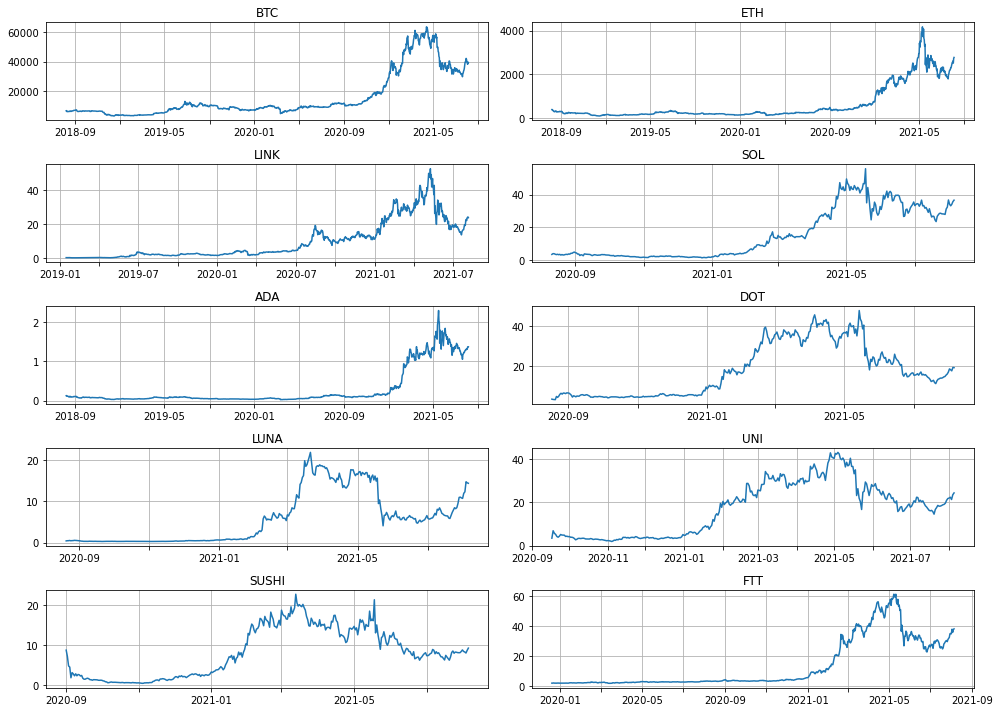

In [202]:
# Plot the individual charts for the coins to dca

fig, ax = plt.subplots(5,2, figsize=(14,10))
for i, ticker in enumerate(all_tickers):
    row, col = i//2, i%2
    ax[row, col].plot(data_df[data_df.ticker == ticker].close)
    ax[row, col].set_title(ticker.upper())
    ax[row, col].grid()
    
    every_nth = 2
    for n, label in enumerate(ax[row,col].xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

fig.tight_layout()
plt.show()

In [203]:
# Scale the df so we can look at the charts together
scaled_df = data_df
scaled_df['avg'] = data_df.groupby('ticker')['close'].transform('mean')
scaled_df['scaled'] = scaled_df.close / scaled_df.avg

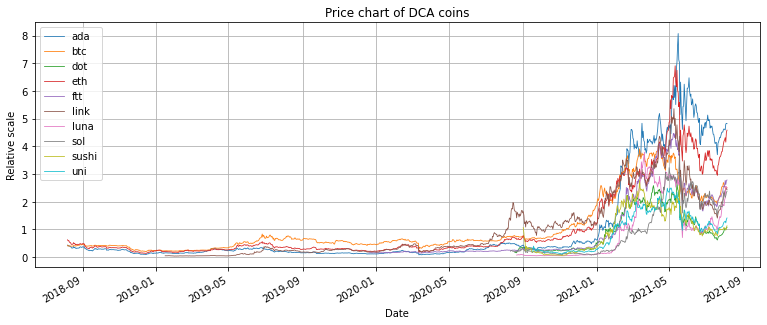

In [204]:
fig = plt.figure(figsize=(13,5))

scaled_df.groupby('ticker')['scaled'].plot(legend=True, linewidth=0.8)

plt.title('Price chart of DCA coins')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Relative scale')
plt.show()

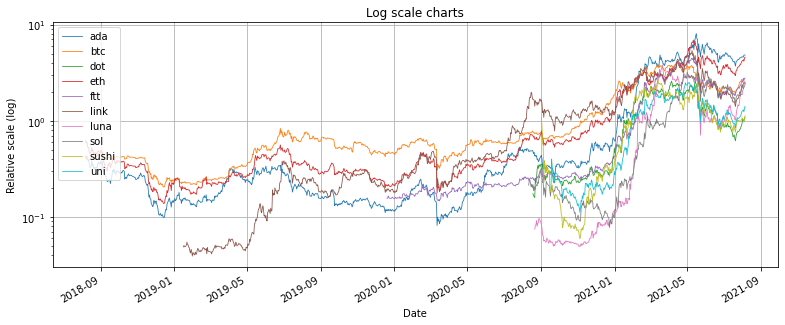

In [205]:
fig = plt.figure(figsize=(13,5))

scaled_df.groupby('ticker')['scaled'].plot(legend=True, logy=True, linewidth=0.8)

plt.title('Log scale charts')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Relative scale (log)')
plt.show()

## The DCA Testing chart

In [232]:
# DCA which gives you the total amount invested over a time period and the average price you would have got
class DCA:
    def __init__(self, total, df, since=datetime.now() - timedelta(days=365*3)):
        self.total = total
        self.since=since
        self.df = df
    
    def weighting(self):
        pass
            
    # Run the dca strategy with the parameters entered
    def get_average(self, dollar_amount, freq, ticker):
        amounts, volumes, spent, break_flag = [], [], 0, False
        
        for i, row in enumerate(self.df[self.df.index > self.since].iterrows()):
            if i % freq == 0:
                volumes.append(dollar_amount / row[1].open)
                amounts.append(1 * row[1].open)
                spent += dollar_amount
                
            if spent >= self.total:
                print('Maximum %.2f invested on: %s' % (spent, row[0].strftime('%b %d %y')))
                break_flag = True
                break
            
        avg_price = sum(amounts) / len(amounts)
        print('DCA Price: $%.6f' % (avg_price))
        print('Spent:     $%.2f' % (spent))
        print('Leftover:  $%.2f' % (self.total - spent))
        print('Made:      $%.2f' % (sum(volumes) * (row[1].open - avg_price)))
        print('Amount:    %.6f %s\n\n' % (sum(volumes), ticker.upper()))
        return volumes
            
    def get_length(self):
        pass


In [233]:
params = {
          'amount':   100000,
          'freq_d':   1,  
         }

for ticker in all_tickers:
    
    print(ticker.upper())
    this_df = data_df[data_df.ticker==ticker]
 
    my_dca = DCA(params['amount'], this_df)
    vols = my_dca.get_average(10, params['freq_d'], ticker)

BTC
DCA Price: $15638.932384
Spent:     $10950.00
Leftover:  $89050.00
Made:      $30698.54
Amount:    1.274632 BTC


ETH
DCA Price: $602.062749
Spent:     $10950.00
Leftover:  $89050.00
Made:      $97510.62
Amount:    45.941677 ETH


LINK
DCA Price: $9.726517
Spent:     $9330.00
Leftover:  $90670.00
Made:      $65654.10
Amount:    4539.928668 LINK


SOL
DCA Price: $15.286005
Spent:     $3600.00
Leftover:  $96400.00
Made:      $17460.78
Amount:    852.952346 SOL


ADA
DCA Price: $0.283834
Spent:     $10950.00
Leftover:  $89050.00
Made:      $169806.82
Amount:    155391.752201 ADA


DOT
DCA Price: $17.668743
Spent:     $3530.00
Leftover:  $96470.00
Made:      $589.95
Amount:    399.355748 DOT


LUNA
DCA Price: $5.740199
Spent:     $3500.00
Leftover:  $96500.00
Made:      $37508.71
Amount:    4277.031231 LUNA


UNI
DCA Price: $17.159694
Spent:     $3230.00
Leftover:  $96770.00
Made:      $2956.00
Amount:    464.027420 UNI


SUSHI
DCA Price: $8.231531
Spent:     $3390.00
Leftover:  $96610

## Fear and Greed index

In [86]:
import requests 
import ast

In [87]:
# TOEDIT # Returned much quicker due to caching, check and test headers with this

In [506]:
endpoint = 'https://api.alternative.me/fng/?limit=2000&format=json&date_format=uk'
fg_data =  requests.get(endpoint).json()

In [507]:
fg_values = pd.DataFrame()
fg_values['fear_greed'] = [int(x['value']) for x in fg_data['data']]
fg_values.index = [x['timestamp'] for x in fg_data['data']]
fg_values.index = pd.to_datetime(fg_values.index, dayfirst=True)

In [508]:
scaled_df_date = scaled_df.copy()
scaled_df_date.index = scaled_df_date.index.date
fg_df = scaled_df_date.join(fg_values)

In [509]:
fg_df

,open,high,low,close,volume,ticker,avg,scaled,fear_greed
2018-08-07,6935.00000,7150.46000,6670.00000,6720.06000,4.543847e+04,btc,15668.575708,0.428888,25
2018-08-07,405.19000,412.76000,369.19000,378.21000,2.077061e+05,eth,604.231142,0.625936,25
2018-08-07,0.12937,0.13227,0.12252,0.12365,1.173828e+08,ada,0.284974,0.433900,25
2018-08-08,6720.63000,6721.54000,6123.00000,6285.00000,5.955054e+04,btc,15668.575708,0.401121,23
2018-08-08,378.20000,380.42000,347.25000,355.48000,2.750471e+05,eth,604.231142,0.588318,23
...,...,...,...,...,...,...,...,...,...
2021-08-05,19.14600,19.45800,17.86100,19.05000,1.393922e+07,dot,17.717019,1.075237,50
2021-08-05,14.51000,15.14900,13.71400,14.40700,7.912193e+06,luna,5.779077,2.492959,50
2021-08-05,23.53000,24.66500,22.05700,24.37200,2.562654e+06,uni,17.233162,1.414250,50
2021-08-05,8.75700,9.44000,8.18000,9.31600,5.041051e+06,sushi,8.240212,1.130553,50


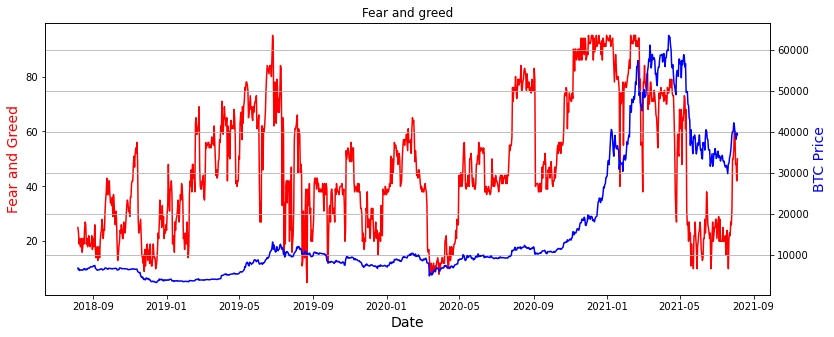

In [510]:

fig,ax = plt.subplots(figsize=(13,5))
ax.plot(fg_df[fg_df.ticker=='btc'].index, fg_df[fg_df.ticker=='btc'].fear_greed, color="red")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Fear and Greed", color="red",fontsize=14)

ax2 = ax.twinx()
ax2.plot(fg_df[fg_df.ticker=='btc'].index, fg_df[fg_df.ticker=='btc'].close, color="blue")
ax2.set_ylabel("BTC Price", color="blue",fontsize=14)


plt.title('Fear and greed')
plt.grid()
plt.show()

In [529]:
# DCA which gives you the total amount invested over a time period and the average price you would have got
class DCA:
    def __init__(self, total, df, since=datetime.now() - timedelta(days=365*3)):
        self.total = total
        self.since=since
        self.df = df
    
            
    # Run the dca strategy with the parameters entered
    def get_average(self, dollar_amount, freq, ticker, weighting=None):
        prices, volumes, spent, break_flag = [], [], 0, False
        
        # Loop over every row
        weight = 1
        for i, row in enumerate(self.df[self.df.index > self.since].iterrows()):
            
            if weighting:
                weight = row[1][weighting]
            
            
            if i % freq == 0:
                if spent + dollar_amount * weight >= self.total:
                    
                    leftover_dollar = self.total - spent
                    volumes.append((leftover_dollar / row[1].open))
                    prices.append(1*row[1].open)
                    spent += leftover_dollar
                    
                    print('Maximum $%.2f invested on: %s' % (spent, row[0].strftime('%b %d %y')))
                    break_flag = True
                    
                    break
                    
                volumes.append(dollar_amount * weight / row[1].open)
                prices.append(1 * row[1].open)
                spent += dollar_amount * weight
                
                
            
#         avg_price = sum(prices) / len(prices)
        
#         print('DCA Price: $%.6f' % (avg_price))
#         print('Spent:     $%.2f' % (spent))
#         print('Leftover:  $%.2f' % (self.total - spent))
#         print('Made:      $%.2f' % (sum(volumes) * (row[1].open - avg_price)))
#         print('Amount:    %.6f %s\n\n' % (sum(volumes), ticker.upper()))

        return volumes, spent, prices
            
    def get_length(self):
        pass


In [530]:
fg_df.mean().fear_greed

51.89063933924748

In [531]:
fg_w_df = fg_df.copy()

In [532]:
line = np.linspace(0,100,101)
weight_df = pd.DataFrame(line, columns=['line'])
weight_df.sort_values('line',ascending=False).reset_index(inplace=True)
weight_df

,line
0,0.0
1,1.0
2,2.0
3,3.0
4,4.0
...,...
96,96.0
97,97.0
98,98.0
99,99.0


In [580]:
# Applies weighting to a df to plot it out
def apply_weighting(df, weight_name, function, xlabel, replace=False):
    
    if weight_name in df.columns and not replace:
        print('Weighting for %s already in df' % name)
        return
    
    df[weight_name] = df.line.apply(function)
    
    plt.figure(figsize=(5,2))
    plt.title(weight_name)
    plt.xlabel(xlabel)
    plt.ylabel('Relative Weight')
    plt.plot(df[[weight_name]])
    plt.grid()
    plt.show()

In [565]:
weight_dict = {}

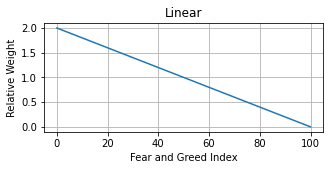

In [567]:
# Weight functions
weight_name = 'Linear'
weight_dict[weight_name] = linear_weight = lambda x : 2*(100-x)/100
apply_weighting(weight_df, weight_name, linear_weight, 'Fear and Greed Index', replace=True)

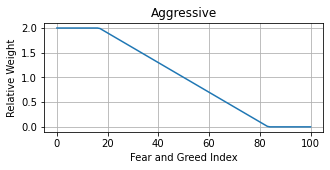

In [568]:
weight_name = 'Aggressive'
weight_dict[weight_name] = agg_weight = lambda x : max(min(3*(100-x) / 100-0.5, 2), 0)
apply_weighting(weight_df, weight_name, agg_weight, 'Fear and Greed Index', replace=True)

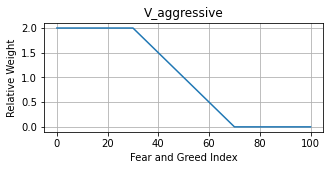

In [569]:
weight_name = 'V_aggressive'
weight_dict[weight_name] = agg_weight = lambda x : max(min(5*(100-x) / 100-1.5, 2), 0)
apply_weighting(weight_df, weight_name, agg_weight, 'Fear and Greed Index', replace=True)

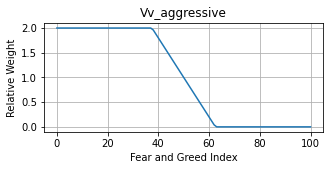

In [570]:
weight_name = 'Vv_aggressive'
weight_dict[weight_name] = agg_weight = lambda x : max(min(8*(100-x) / 100-3, 2), 0)
apply_weighting(weight_df, weight_name, agg_weight, 'Fear and Greed Index', replace=True)

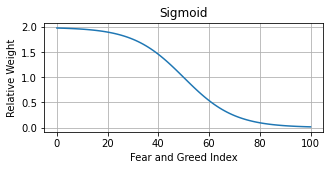

In [738]:
weight_name = 'Sigmoid'
weight_dict[weight_name] = agg_weight = lambda x : - 2 / (1 + np.exp(-0.1*(x-50))) + 2
apply_weighting(weight_df, weight_name, agg_weight, 'Fear and Greed Index', replace=True)

In [739]:
for weight_name, weight_func in weight_dict.items():
    fg_w_df['fg_%s' % (weight_name)] =  fg_w_df.fear_greed.apply(weight_func)

In [740]:
params = {
          'amount':   90000,
          'freq_d':   1,
          'dollar':   100
         }


for ticker in all_tickers:
    if ticker == 'btc':

        print(ticker.upper(),'\n')
        this_df = fg_w_df[fg_w_df.ticker==ticker]

        my_dca = DCA(params['amount'], this_df)


        vols, spent, prices = my_dca.get_average(params['dollar'], params['freq_d'], ticker, )
        print('Regular DCA:    %.6f %s   $%.2f Leftover\n' % (sum(vols), ticker.upper(), params['amount'] - spent))

        # Calculating the bought volume for the each
        for weight_name in weight_dict:
            vols, spent, prices = my_dca.get_average(params['dollar'], params['freq_d'], ticker, weighting='fg_%s'%(weight_name))
            print('%s DCA:    %.6f %s    $%.2f Leftover\n' % (weight_name, sum(vols), ticker.upper(), params['amount'] - spent))

        print('\n\n')

BTC 

Maximum $90000.00 invested on: Jan 22 21
Regular DCA:    12.290195 BTC   $0.00 Leftover

Maximum $90000.00 invested on: Sep 07 20
Linear DCA:    14.035196 BTC    $0.00 Leftover

Maximum $90000.00 invested on: Jun 16 20
Aggressive DCA:    14.553515 BTC    $0.00 Leftover

Maximum $90000.00 invested on: May 06 20
V_aggressive DCA:    14.829789 BTC    $0.00 Leftover

Maximum $90000.00 invested on: Apr 23 20
Vv_aggressive DCA:    14.870312 BTC    $0.00 Leftover

Maximum $90000.00 invested on: May 28 20
Sigmoid DCA:    14.639362 BTC    $0.00 Leftover






## Exponentially decreasing with price

In [682]:
exp_df = fg_df.copy()

In [693]:
max_price = 30000
min_price = 1000
aggression = 1
expstr = 'exp_'

In [694]:
exp_dict = {}
line = np.linspace(min_price, max_price, 101)

exp_weight_df = pd.DataFrame(line, columns=['line'])
exp_weight_df.sort_values('line',ascending=False).reset_index(inplace=True)
exp_weight_df.index = exp_weight_df.line
exp_weight_df

,line
line,
1000.0,1000.0
1290.0,1290.0
1580.0,1580.0
1870.0,1870.0
2160.0,2160.0
...,...
28840.0,28840.0
29130.0,29130.0
29420.0,29420.0


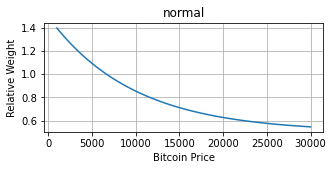

In [695]:
weight_name = 'normal'
# exp_dict[weight_name] = agg1 = lambda x : np.exp(-x/(max_price-min_price)*3+1.2)
exp_dict[weight_name] = agg1 = lambda x : np.exp(-3*x/(max_price-min_price))+0.5
apply_weighting(exp_weight_df, weight_name, agg1, 'Bitcoin Price', replace=True)

In [696]:
for weight_name, weight_func in exp_dict.items():
    exp_df['%s%s' % (expstr, weight_name)] =  exp_df.close.apply(weight_func)

In [697]:
params = {
          'amount':   90000,
          'freq_d':   1,
          'dollar':   100
         }

df = exp_df


for ticker in all_tickers:
    if ticker == 'btc':

        print(ticker.upper(),'\n')
        this_df = df[df.ticker==ticker]

        my_dca = DCA(params['amount'], this_df)


        vols, spent, prices = my_dca.get_average(params['dollar'], params['freq_d'], ticker, )
        print('Regular DCA:    %.6f %s   $%.2f Leftover\n' % (sum(vols), ticker.upper(), params['amount'] - spent))

        # Calculating the bought volume for the each
        for weight_name in exp_dict:
            vols, spent, prices = my_dca.get_average(params['dollar'], params['freq_d'], ticker, weighting='%s%s'%(expstr, weight_name))
            print('%s DCA:    %.6f %s    $%.2f Leftover\n' % (weight_name, sum(vols), ticker.upper(), params['amount'] - spent))

        print('\n\n')

BTC 

Maximum $90000.00 invested on: Jan 22 21
Regular DCA:    12.290195 BTC   $0.00 Leftover

Maximum $90000.00 invested on: May 31 21
normal DCA:    12.382196 BTC    $0.00 Leftover




